# LiDAR FRC Field Position Calculations

This is a notebook that displays how to use Lidar points to align a robot to an FRC Field to produce a position and heading on the field.

This is the code to port over as a single file for use on the RPi Platform

In [1]:
### frc_lidar.py
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, atan2, pi

def get_correspondence_indices(P, Q):
    """For each point in P find closest one in Q."""
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

def draw_correspondeces(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        if not label_added:
            ax.plot(x, y, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, color='grey')
    ax.legend()
    
def center_data(data, exclude_indices=[]):
    reduced_data = np.delete(data, exclude_indices, axis=1)
    center = np.array([reduced_data.mean(axis=1)]).T
    return center, data - center

def compute_cross_covariance(P, Q, correspondences, kernel=lambda diff: 1.0):
    cov = np.zeros((2, 2))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        weight = kernel(p_point - q_point)
        if weight < 0.01: exclude_indices.append(i)
        cov += weight * q_point.dot(p_point.T)
    return cov, exclude_indices

def icp_svd(P, Q, iterations=10, kernel=lambda diff: 1.0):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = center_data(Q)
    norm_values = []
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    exclude_indices = []
    for i in range(iterations):
        center_of_P, P_centered = center_data(P_copy, exclude_indices=exclude_indices)
        correspondences = get_correspondence_indices(P_centered, Q_centered)
        corresp_values.append(correspondences)
        norm_values.append(np.linalg.norm(P_centered - Q_centered))
        cov, exclude_indices = compute_cross_covariance(P_centered, Q_centered, correspondences, kernel)
        U, S, V_T = np.linalg.svd(cov)
        R = U.dot(V_T)  
        t = center_of_Q - R.dot(center_of_P)  
        P_copy = R.dot(P_copy) + t
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, norm_values, corresp_values

### The below code is for plotting the data on charts

We don't need to include any of this code on the robot

In [2]:
from matplotlib import animation, rc
from IPython.display import display, Math, Latex, Markdown, HTML

def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    if data_1 is not None:
        x_p, y_p = data_1
        ax.plot(x_p, y_p, color='#336699', markersize=markersize_1, marker='o', linestyle=":", label=label_1)
    if data_2 is not None:
        x_q, y_q = data_2
        ax.plot(x_q, y_q, color='orangered', markersize=markersize_2, marker='o', linestyle=":", label=label_2)
    ax.legend()
    return ax

def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()
    
def animate_results(P_values, Q, corresp_values, xlim, ylim):
    """A function used to animate the iterative processes we use."""
    fig = plt.figure(figsize=(10, 6))
    anim_ax = fig.add_subplot(111)
    anim_ax.set(xlim=xlim, ylim=ylim)
    anim_ax.set_aspect('equal')
    plt.close()
    x_q, y_q = Q
    # draw initial correspondeces
    corresp_lines = []
    for i, j in correspondences:
        corresp_lines.append(anim_ax.plot([], [], 'grey')[0])
    # Prepare Q data.
    Q_line, = anim_ax.plot(x_q, y_q, 'o', color='orangered')
    # prepare empty line for moved data
    P_line, = anim_ax.plot([], [], 'o', color='#336699')

    def animate(i):
        P_inc = P_values[i]
        x_p, y_p = P_inc
        P_line.set_data(x_p, y_p)
        draw_inc_corresp(P_inc, Q, corresp_values[i])
        return (P_line,)
    
    def draw_inc_corresp(points_from, points_to, correspondences):
        for corr_idx, (i, j) in enumerate(correspondences):
            x = [points_from[0, i], points_to[0, j]]
            y = [points_from[1, i], points_to[1, j]]
            corresp_lines[corr_idx].set_data(x, y)
    
    anim = animation.FuncAnimation(fig, animate,
                                   frames=len(P_values), 
                                   interval=500, 
                                   blit=True)
    return HTML(anim.to_jshtml())

### Example Data

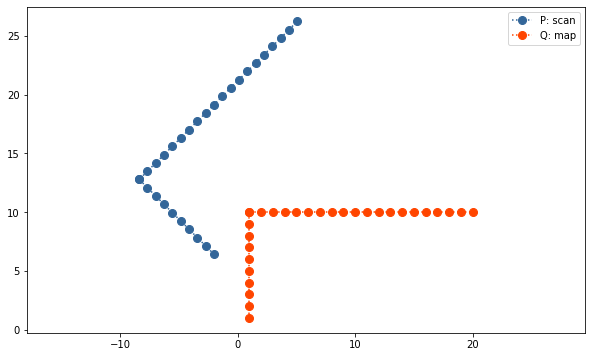

In [3]:
# initialize pertrubation rotation
angle = pi / 4
R_true = np.array([[cos(angle), -sin(angle)], 
                   [sin(angle),  cos(angle)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
sin_true_data = np.zeros((2, num_points))
sin_true_data[0, :] = range(0, num_points)
sin_true_data[1, :] = 0.2 * sin_true_data[0, :] * np.sin(0.5 * sin_true_data[0, :]) 
# Move the data
sin_moved_data = R_true.dot(sin_true_data) + t_true

field = np.zeros((2, num_points))
#scan = np.zeros((2, 500))



field[0, :] = range(0, num_points)

field[0, 0] = 1
field[1, 0] = 1
field[0, 1] = 1
field[1, 1] = 2
field[0, 2] = 1
field[1, 2] = 3
field[0, 3] = 1
field[1, 3] = 4
field[0, 4] = 1
field[1, 4] = 5
field[0, 5] = 1
field[1, 5] = 6
field[0, 6] = 1
field[1, 6] = 7
field[0, 7] = 1
field[1, 7] = 8
field[0, 8] = 1
field[1, 8] = 9
field[0, 9] = 1
field[1, 9] = 10
field[0, 10] = 1
field[1, 10] = 10
field[0, 11] = 2
field[1, 11] = 10
field[0, 12] = 3
field[1, 12] = 10
field[0, 13] = 4
field[1, 13] = 10
field[0, 14] = 5
field[1, 14] = 10
field[0, 15] = 6
field[1, 15] = 10
field[0, 16] = 7
field[1, 16] = 10
field[0, 17] = 8
field[1, 17] = 10
field[0, 18] = 9
field[1, 18] = 10
field[0, 19] = 10
field[1, 19] = 10
field[0, 20] = 11
field[1, 20] = 10
field[0, 21] = 12
field[1, 21] = 10
field[0, 22] = 13
field[1, 22] = 10
field[0, 23] = 14
field[1, 23] = 10
field[0, 24] = 15
field[1, 24] = 10
field[0, 25] = 16
field[1, 25] = 10
field[0, 26] = 17
field[1, 26] = 10
field[0, 27] = 18
field[1, 27] = 10
field[0, 28] = 19
field[1, 28] = 10
field[0, 29] = 20
field[1, 29] = 10


scan = R_true.dot(field) + t_true


# Assign to variables we use in formulas.
Q = field
P = scan

plot_data(P, Q, "P: scan", "Q: map")
plt.show()

### Center both in graph

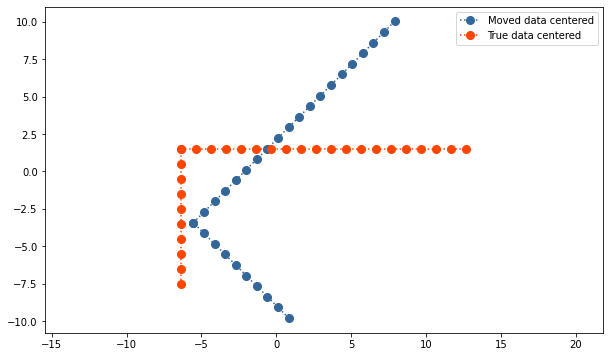

In [4]:
center_of_P, P_centered = center_data(P)
center_of_Q, Q_centered = center_data(Q)
ax = plot_data(P_centered, Q_centered,
               label_1='Moved data centered',
               label_2='True data centered')
plt.show()


### Calculate corresponences

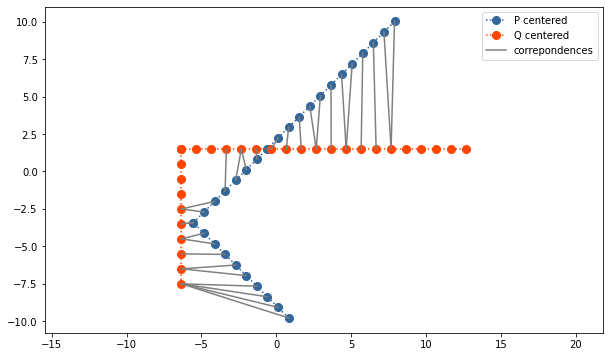

In [5]:
correspondences = get_correspondence_indices(P_centered, Q_centered)
ax = plot_data(P_centered, Q_centered,
               label_1='P centered',
               label_2='Q centered')
draw_correspondeces(P_centered, Q_centered, correspondences, ax)
plt.show()

### Compute Cross Covariance

In [6]:
cov, _ = compute_cross_covariance(P_centered, Q_centered, correspondences)
print(cov)

[[531.27289493 840.98566509]
 [215.07831261 565.0961693 ]]


### Iterative Example

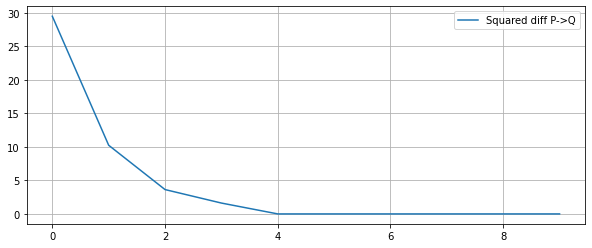

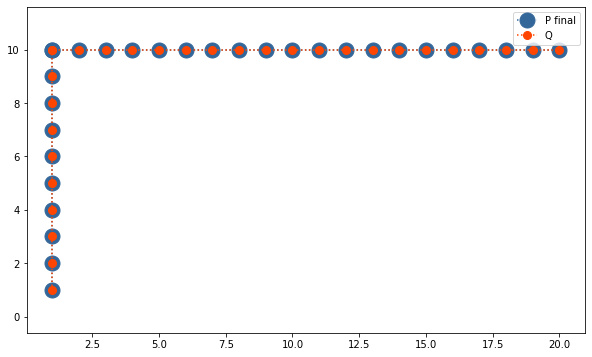

[29.485669477074193, 10.24253253815051, 3.6311305864082346, 1.6199476518144718, 2.597067719494363e-14, 3.21221117616679e-14, 3.075458055899955e-14, 3.0767402982137026e-14, 3.092085731553811e-14, 3.112428620244009e-14]


In [7]:
P_values, norm_values, corresp_values = icp_svd(P, Q)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)

In [8]:
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-5, 35))